In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [32]:
closed_loop = functions.get_participation(
    st.data,
    manipulation_epochs["closed_loop"].starts,
    manipulation_epochs["closed_loop"].stops,
    par_type="firing_rate",
)
closed_loop.mean(axis=1)

array([  4.33231397,   3.82262997,  12.8950051 ,   2.19164118,
        10.14271152,   2.54841998,   6.21814475,   9.27624873,
         3.31294597,   5.09683996,   3.41488277,   9.73496432,
       192.60958206, 113.50662589,  17.17635066,  19.87767584,
         3.66972477,   3.00713558,  16.20795107,   3.41488277,
        37.3598369 ,   2.14067278,   7.39041794,   0.5606524 ,
         0.509684  , 118.70540265, 127.82874618,   2.08970438,
         7.59429154,  86.69724771,  47.80835882, 258.61365953,
         9.73496432,  17.48216106,  22.62996942,  20.64220183,
        34.76044852,  22.78287462,  18.55249745,  40.41794088,
        11.56982671,   7.69622834,   0.5606524 ,  35.52497452,
         3.77166157,  21.30479103,   3.72069317, 327.11518858,
        31.90621814,  41.38634047,  21.35575943,   1.63098879,
         1.63098879,   5.55555556,  15.64729867,  79.15392457,
       113.86340469,  86.08562691,   3.72069317,   3.66972477])

In [49]:
closed_loop[closed_loop == 0] = np.nan
closed_loop

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan, 100., 100., ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [71]:
st.n_spikes / (st.last_event - st.first_event)

array([0.73328819, 0.20169667, 0.59374821, 1.62178949, 0.12918053,
       0.0415271 , 0.19933007, 0.21719119, 0.0910917 , 0.3946414 ,
       0.41415467, 0.29872719, 1.76789343, 1.10270075, 0.82571947,
       0.68448268, 0.09006469, 0.16124124, 0.4962265 , 0.14391596,
       0.11457907, 0.19839237, 0.09068983, 0.01263674, 0.00727841,
       5.22049214, 4.3330625 , 0.06251391, 0.0670685 , 3.32176602,
       3.53784089, 2.61995805, 1.49917292, 1.27702526, 1.80817025,
       1.31846306, 1.26126283, 0.89752117, 0.79499835, 0.71181019,
       0.41227925, 0.42947058, 0.01294931, 0.40522411, 0.31922283,
       0.30716657, 0.06336232, 6.83107378, 1.06639803, 2.37334067,
       0.70060234, 0.08345607, 0.52953749, 0.16079471, 0.25684287,
       4.51930931, 2.64822327, 0.98396897, 0.29104691, 0.143782  ])

In [74]:
# basepath = [r"Z:\Data\ORproject\OR15\hc300118", r"\Data\ORproject\OR15\hc280118"]
df = pd.DataFrame()

for basepath in [r"Z:\Data\ORproject\OR15\hc300118", r"Z:\Data\ORproject\OR15\hc280118"]:

    manipulation_epochs = loading.load_manipulation(
        basepath, struct_name="optoStim", return_epoch_array=True
    )
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    closed_loop = functions.get_participation(
        st.data,
        manipulation_epochs["closed_loop"].starts,
        manipulation_epochs["closed_loop"].stops,
        par_type="firing_rate",
    )
    delayed = functions.get_participation(
        st.data,
        manipulation_epochs["delayed"].starts,
        manipulation_epochs["delayed"].stops,
        par_type="firing_rate",
    )
    
    temp_df = pd.DataFrame()

    temp_df["baseline_fr"] = np.hstack(
        [st.n_spikes / (st.last_event - st.first_event), st.n_spikes / (st.last_event - st.first_event)]
    )

    temp_df["participation"] = np.hstack(
        [(closed_loop > 0).mean(axis=1), (delayed > 0).mean(axis=1)]
    )
    temp_df["avg_stim_firing_rate"] = np.hstack(
        [closed_loop.mean(axis=1), delayed.mean(axis=1)]
    )

    closed_loop[closed_loop == 0] = np.nan
    delayed[delayed == 0] = np.nan

    temp_df["avg_firing_rate_if_par"] = np.hstack(
        [np.nanmean(closed_loop,axis=1), np.nanmean(delayed,axis=1)]
    )

    temp_df["stim_type"] = np.hstack(
        [
            np.repeat("closed_loop", closed_loop.shape[0]),
            np.repeat("delayed", delayed.shape[0]),
        ]
    )
    temp_df["stim_type"] = temp_df["stim_type"].astype("category")

    temp_df["deepSuperficial"] = np.hstack([cm.deepSuperficial, cm.deepSuperficial])
    temp_df["deepSuperficial"] = temp_df["deepSuperficial"].astype("category")
    temp_df["deepSuperficialDistance"] = np.hstack(
        [cm.deepSuperficialDistance, cm.deepSuperficialDistance]
    )
    df = pd.concat([df, temp_df], ignore_index=True)

df["stim_gain"] = df["avg_stim_firing_rate"] / df["baseline_fr"]    
df


C:\Users\Cornell\AppData\Local\Temp\ipykernel_11888\1457352273.py:42: RuntimeWarning: Mean of empty slice
C:\Users\Cornell\AppData\Local\Temp\ipykernel_11888\1457352273.py:42: RuntimeWarning: Mean of empty slice


,baseline_fr,participation,avg_stim_firing_rate,avg_firing_rate_if_par,stim_type,deepSuperficial,deepSuperficialDistance,stim_gain
0,0.134743,0.006308,0.630828,100.000000,closed_loop,Deep,-145.736540,4.681724
1,1.307005,0.271530,35.655513,131.313131,closed_loop,Deep,-165.686232,27.280328
2,0.321245,0.052386,6.226001,118.848168,closed_loop,middle,-28.817655,19.380834
3,0.871925,0.016731,1.919912,114.754098,closed_loop,Deep,-195.604452,2.201924
4,2.054548,0.978881,542.759188,554.469039,closed_loop,Deep,-145.604452,264.174504
...,...,...,...,...,...,...,...,...
271,4.519309,0.291911,38.686987,132.530120,delayed,middle,0.000000,8.560376
272,2.648223,0.624853,129.425557,207.129456,delayed,middle,-26.529709,48.872600
273,0.983969,0.509965,71.864009,140.919540,delayed,Deep,-46.529709,73.034833
274,0.291047,0.022274,2.227433,100.000000,delayed,middle,-6.529709,7.653174


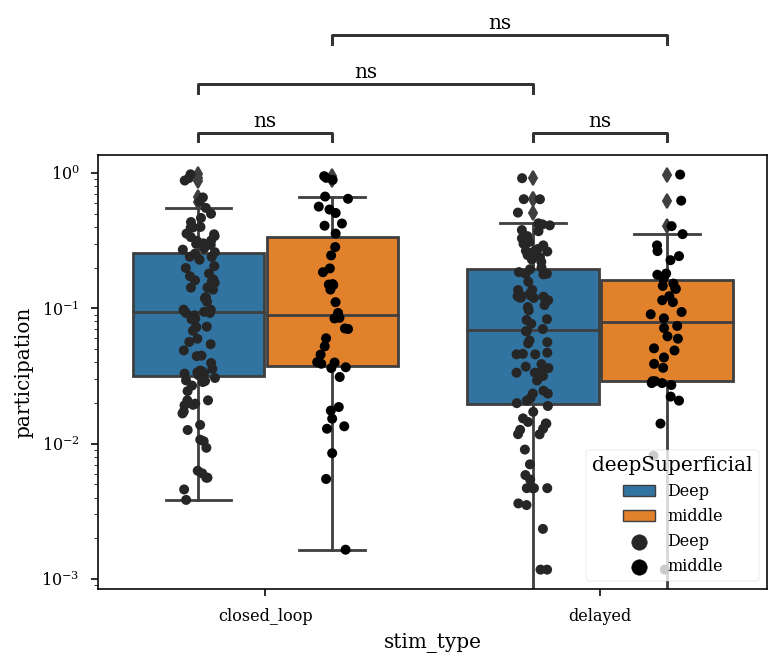

In [75]:
from statannotations.Annotator import Annotator
sns.boxplot(x='stim_type',y='participation',hue="deepSuperficial",data=df)
sns.stripplot(x='stim_type',y='participation',hue="deepSuperficial",data=df,dodge=True,color="black")
plt.yscale('log')

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "middle")),
    (("delayed", "Deep"),("delayed", "middle")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "middle"),("delayed", "middle")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df,
    x="stim_type",
    y="participation",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()

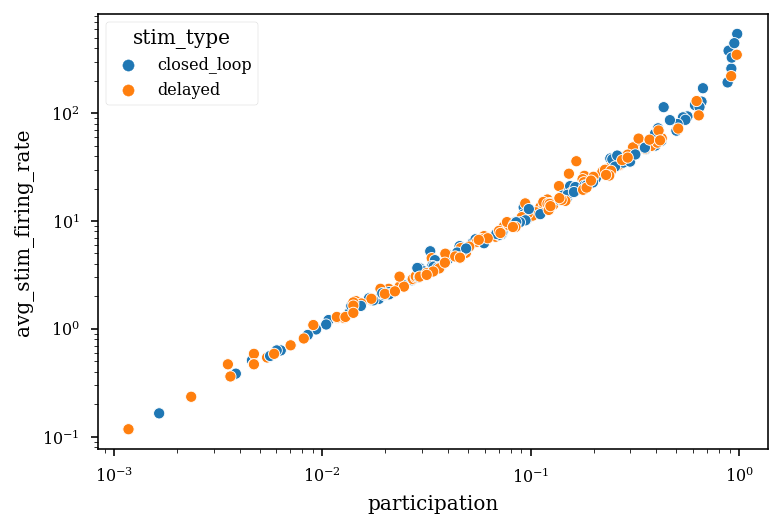

In [76]:
sns.scatterplot(x='participation',y='avg_stim_firing_rate',hue="stim_type",data=df)
plt.yscale('log')
plt.xscale('log')

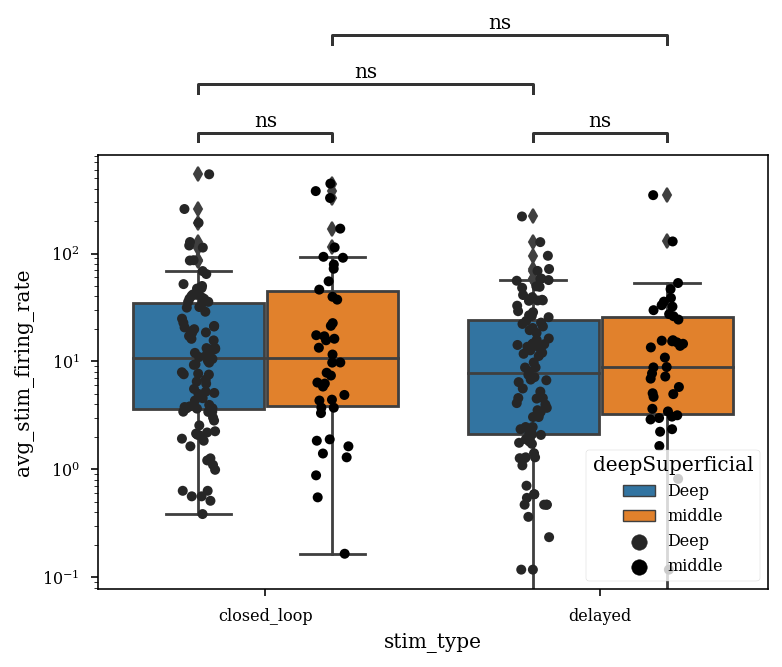

In [62]:
sns.boxplot(x='stim_type',y='avg_stim_firing_rate',hue="deepSuperficial",data=df)
sns.stripplot(x='stim_type',y='avg_stim_firing_rate',hue="deepSuperficial",data=df,dodge=True,color="black")
plt.yscale('log')

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "middle")),
    (("delayed", "Deep"),("delayed", "middle")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "middle"),("delayed", "middle")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df,
    x="stim_type",
    y="avg_stim_firing_rate",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


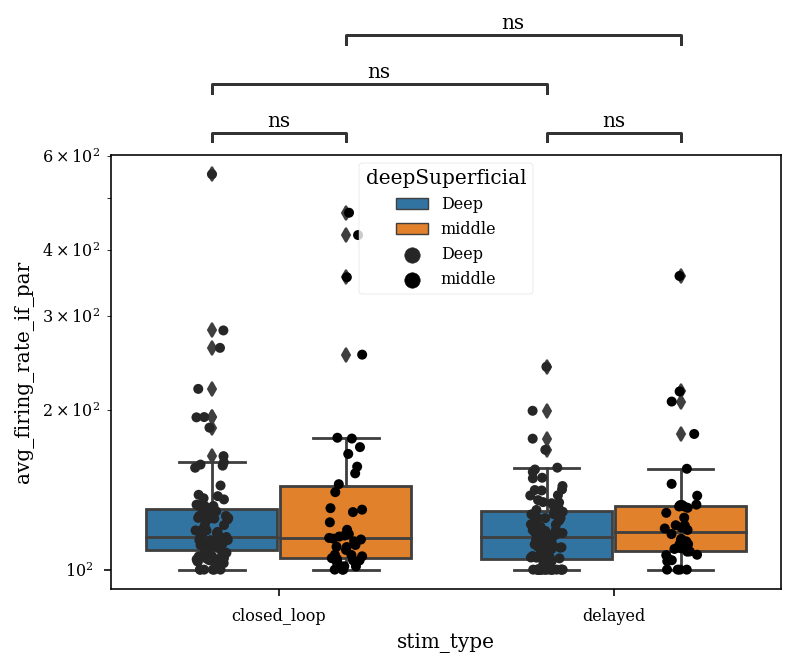

In [59]:
sns.boxplot(x='stim_type',y='avg_firing_rate_if_par',hue="deepSuperficial",data=df)
sns.stripplot(x='stim_type',y='avg_firing_rate_if_par',hue="deepSuperficial",data=df,dodge=True,color="black")
plt.yscale('log')

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "middle")),
    (("delayed", "Deep"),("delayed", "middle")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "middle"),("delayed", "middle")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df,
    x="stim_type",
    y="avg_firing_rate_if_par",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


In [77]:
df

,baseline_fr,participation,avg_stim_firing_rate,avg_firing_rate_if_par,stim_type,deepSuperficial,deepSuperficialDistance,stim_gain
0,0.134743,0.006308,0.630828,100.000000,closed_loop,Deep,-145.736540,4.681724
1,1.307005,0.271530,35.655513,131.313131,closed_loop,Deep,-165.686232,27.280328
2,0.321245,0.052386,6.226001,118.848168,closed_loop,middle,-28.817655,19.380834
3,0.871925,0.016731,1.919912,114.754098,closed_loop,Deep,-195.604452,2.201924
4,2.054548,0.978881,542.759188,554.469039,closed_loop,Deep,-145.604452,264.174504
...,...,...,...,...,...,...,...,...
271,4.519309,0.291911,38.686987,132.530120,delayed,middle,0.000000,8.560376
272,2.648223,0.624853,129.425557,207.129456,delayed,middle,-26.529709,48.872600
273,0.983969,0.509965,71.864009,140.919540,delayed,Deep,-46.529709,73.034833
274,0.291047,0.022274,2.227433,100.000000,delayed,middle,-6.529709,7.653174


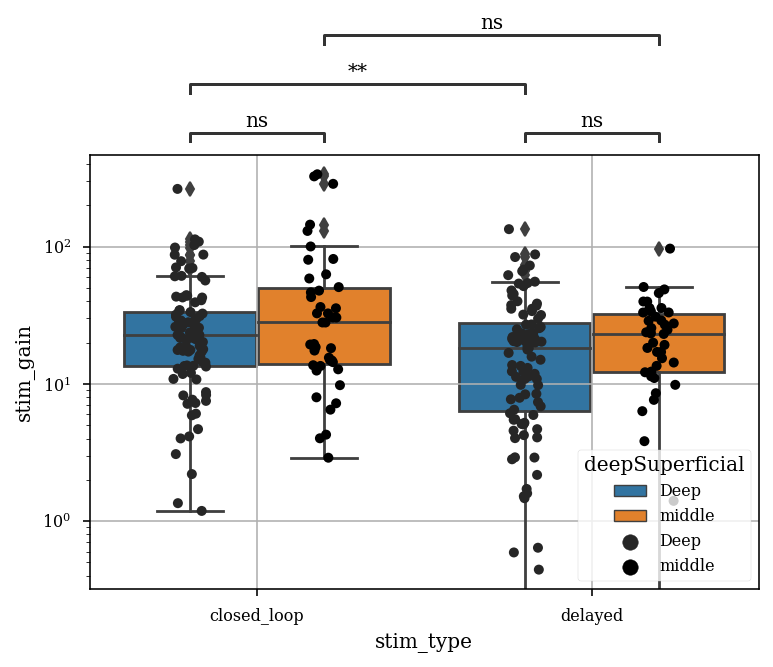

In [79]:
sns.boxplot(x='stim_type',y='stim_gain',hue="deepSuperficial",data=df)
sns.stripplot(x='stim_type',y='stim_gain',hue="deepSuperficial",data=df,dodge=True,color="black")
plt.yscale('log')

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "middle")),
    (("delayed", "Deep"),("delayed", "middle")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "middle"),("delayed", "middle")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df,
    x="stim_type",
    y="stim_gain",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.grid()
plt.show()


## testing below

In [4]:
manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim",return_epoch_array=False
)

display(manipulation_epochs)

manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim",return_epoch_array=True
)

display(manipulation_epochs)

,start,stop,peaks,center,duration,amplitude,amplitudeUnits,ev_label
0,3.41255,3.51255,3.46255,3.46255,0.1,NaN,au,closed_loop
1,10.43515,10.53515,10.48515,10.48515,0.1,NaN,au,closed_loop
2,22.50845,22.60845,22.55845,22.55845,0.1,NaN,au,closed_loop
3,34.28070,34.38070,34.33070,34.33070,0.1,NaN,au,closed_loop
4,37.22515,37.32515,37.27515,37.27515,0.1,NaN,au,closed_loop
...,...,...,...,...,...,...,...,...
4747,21327.19765,21327.29765,21327.24765,21327.24765,0.1,NaN,au,delayed
4748,21366.13200,21366.23200,21366.18200,21366.18200,0.1,NaN,au,delayed
4749,21491.72590,21491.82590,21491.77590,21491.77590,0.1,NaN,au,delayed
4750,21510.06840,21510.16840,21510.11840,21510.11840,0.1,NaN,au,delayed


{'closed_loop': <EpochArray at 0x19a4851fb20: 3,646 epochs> of length 6:04:600 minutes,
 'delayed': <EpochArray at 0x19a4851fac0: 1,106 epochs> of length 1:50:600 minutes}

In [5]:
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)


In [6]:
fr_mat = functions.get_participation(st.data,manipulation_epochs['closed_loop'].starts, manipulation_epochs['closed_loop'].stops,par_type="binary")

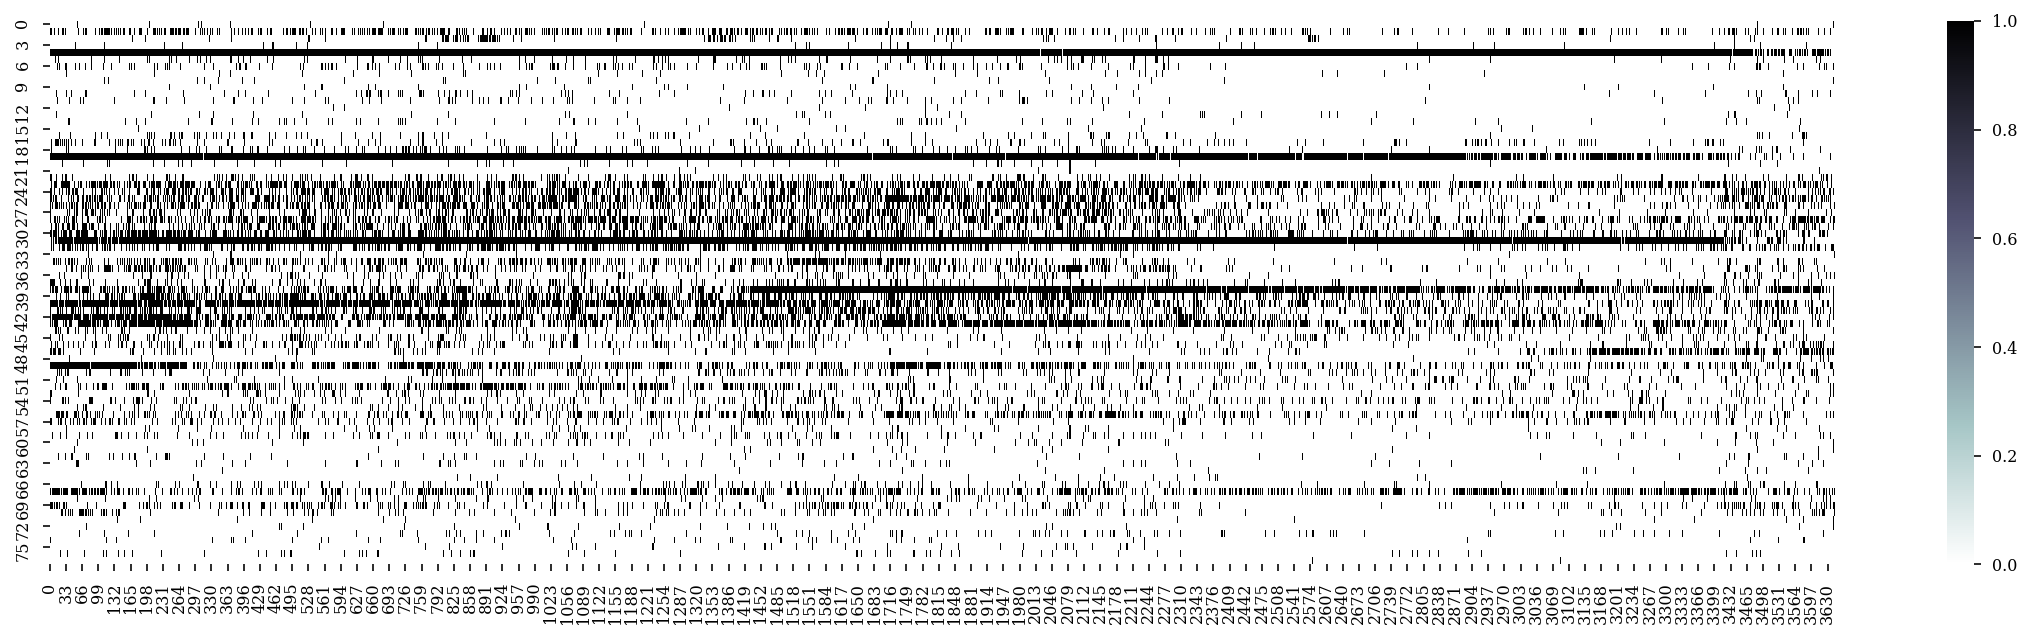

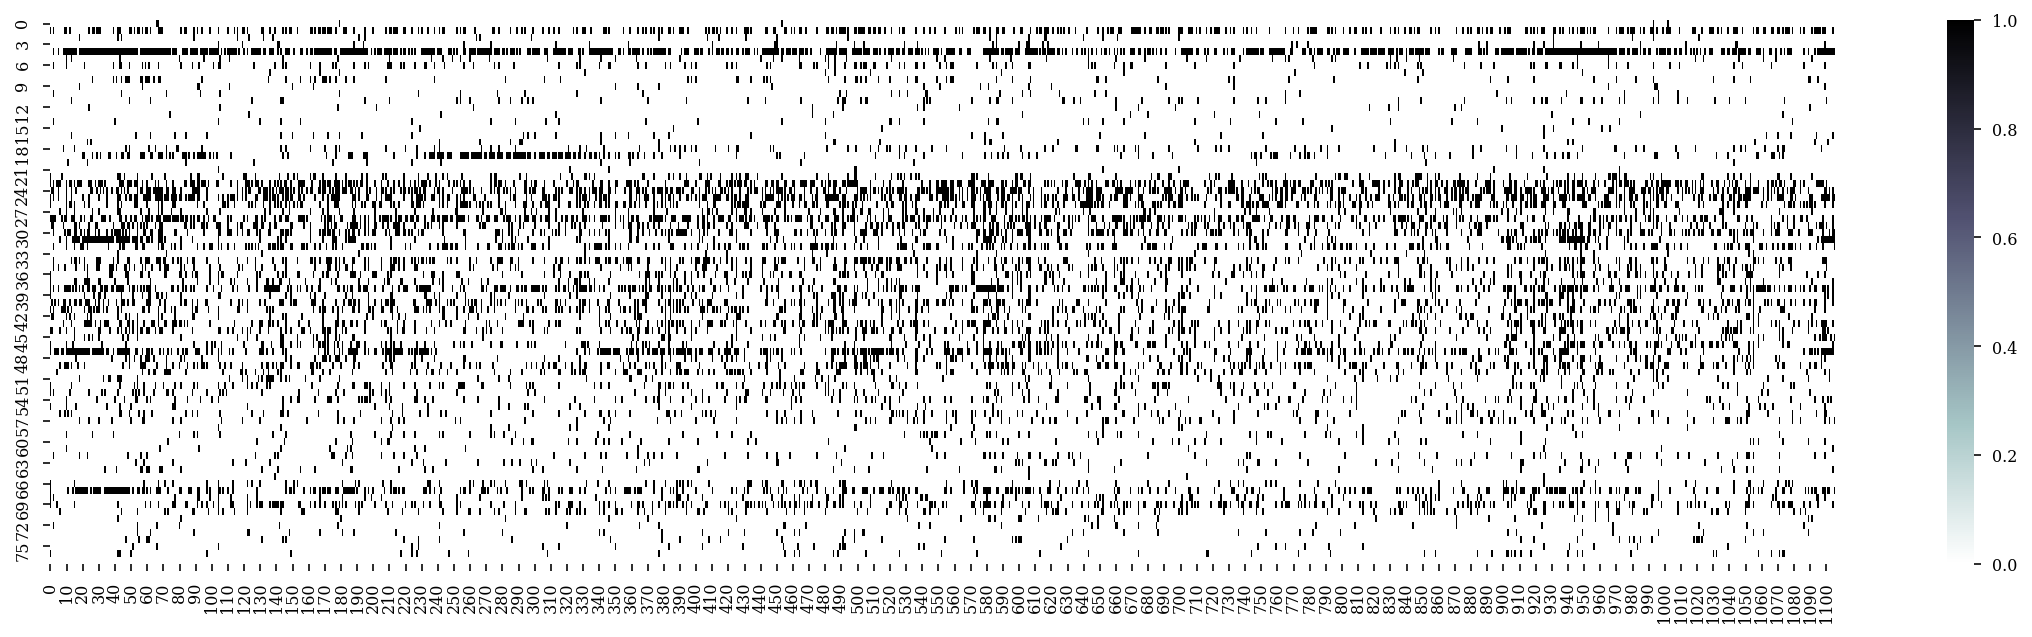

In [7]:
closed_loop = functions.get_participation(st.data,manipulation_epochs['closed_loop'].starts, manipulation_epochs['closed_loop'].stops,par_type="binary")
plt.figure(figsize=(20,5))
sns.heatmap(closed_loop,cmap="bone_r")
plt.show()

delayed = functions.get_participation(st.data,manipulation_epochs['delayed'].starts, manipulation_epochs['delayed'].stops,par_type="binary")
plt.figure(figsize=(20,5))
sns.heatmap(delayed,cmap="bone_r")
plt.show()

In [8]:
df = pd.DataFrame()
df['participation'] = np.hstack([closed_loop.mean(axis=1),delayed.mean(axis=1)])
df['stim_type'] = np.hstack([np.repeat('closed_loop',closed_loop.shape[0]),np.repeat('delayed',delayed.shape[0])])
df['deepSuperficial'] = np.hstack([cm.deepSuperficial,cm.deepSuperficial])
df['deepSuperficialDistance'] = np.hstack([cm.deepSuperficialDistance,cm.deepSuperficialDistance])

df

,participation,stim_type,deepSuperficial,deepSuperficialDistance
0,0.006308,closed_loop,Deep,-145.736540
1,0.271530,closed_loop,Deep,-165.686232
2,0.052386,closed_loop,middle,-28.817655
3,0.016731,closed_loop,Deep,-195.604452
4,0.978881,closed_loop,Deep,-145.604452
...,...,...,...,...
151,0.038879,delayed,middle,-28.817655
152,0.036166,delayed,Deep,-115.736540
153,0.028029,delayed,middle,11.182345
154,0.046112,delayed,Deep,-155.604452


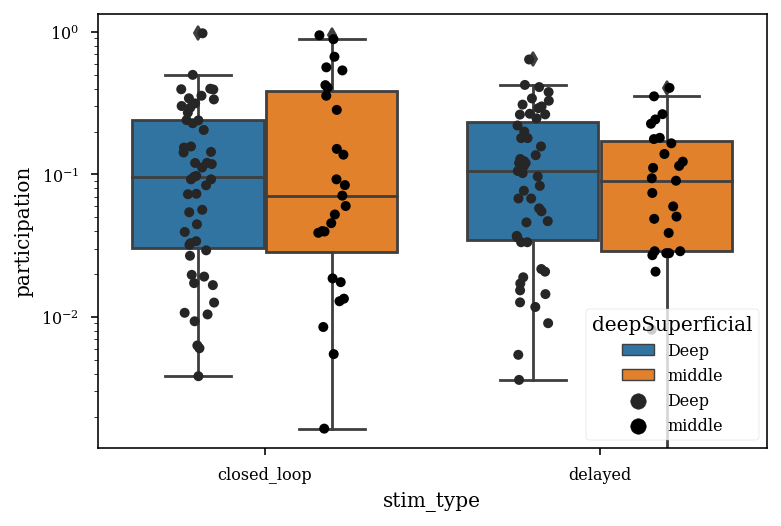

In [11]:
sns.boxplot(x='stim_type',y='participation',hue="deepSuperficial",data=df)
sns.stripplot(x='stim_type',y='participation',hue="deepSuperficial",data=df,dodge=True,color="black")
plt.yscale('log')

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='participation'>

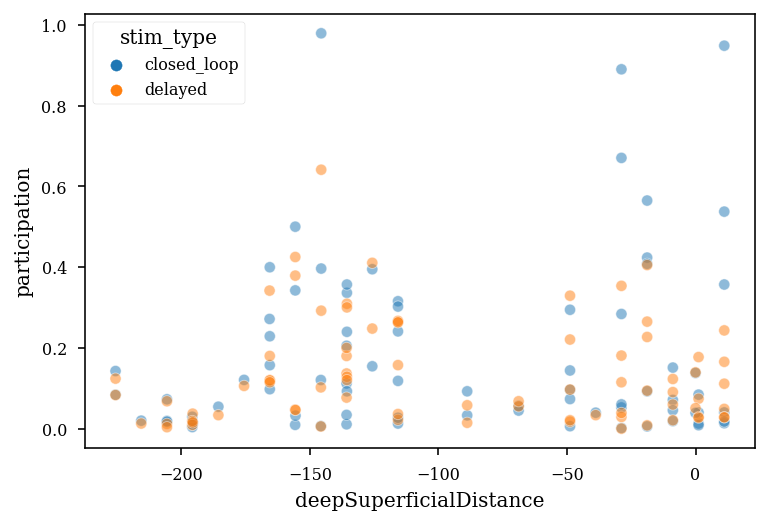

In [10]:
sns.scatterplot(x='deepSuperficialDistance',y='participation',hue='stim_type',data=df,alpha=0.5)

(0.0, 1.0)

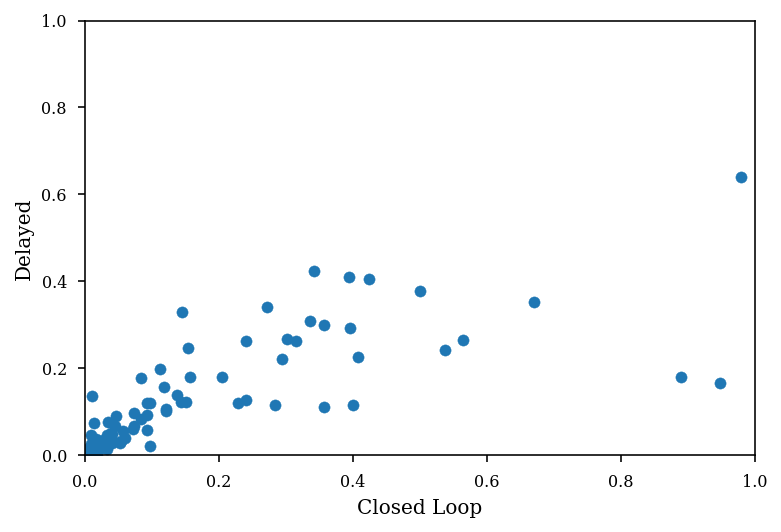

In [104]:
plt.scatter(closed_loop.mean(axis=1),delayed.mean(axis=1))
plt.xlabel("Closed Loop")
plt.ylabel("Delayed")
plt.xlim([0,1])
plt.ylim([0,1])

In [ ]:
pearson = np.corrcoef(closed_loop,delayed)

sns.heatmap(pearson,cmap="RdBu_r",vmin=-.5,vmax=.5)